# Hierarchical Attention Networks

We are interested in automatically classifying a document into a particular class of a predetermined set. This set of classes could be the document's rating, its subject, the year it was written, etc.

One solution to this task is to create a parameterized model which takes a document as input and outputs a probability for each class. We can then find model parameters ($\theta$) which maximize the log-likelihood,
$$ max_\theta \sum_{d} \log p_{dj} $$
where $p_{dj}$ is the model's predicted probability for document $d$'s ground-truth label $j$.

In [Hierarchical Attention Networks for Document Classification](https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf), Yang et al. propose a neural network model which creates a hierarchy of vector representations for the words and sentences in the document, and for the document itself. At each step in the hierarchy, there is a funnel of information, from the many words to the single sentence it forms, and from the many sentences to the single document it forms. The authors propose the use of an attention mechanism to keep the important information at each step. A linear classifier then uses the final vector for the document to predict the document class probabilities.

Specifically, we begin by mapping our words to word vector embeddings. We then use a 1-layer bidirectional GRU to create context dependent word representations. We then take a weighted sum of these vectors to produce a vector representation for the sentence. These weights are determined by taking the softmax of the dot products between each context dependent word representation and a "query word". This query word is learned jointly with the entire model. We call this mechanism "attention". The document vector is created from the sentence vectors in the same way, a 1-layer bidirectional GRU and attention. We can then optimize the model with a modification of standard stochastic gradient descent, [Adam](https://arxiv.org/abs/1412.6980).

## Overview

We will first explore the "Yelp Review Polarity" dataset, prepare the dataset for training, and train our implementation of a hierarchical attention network on the dataset. We will then examine the results by seeing its accuracy on the test set and by visualizing the attention mechanism.

## The Yelp Review Polarity Task

Let's begin by downloading the "Yelp Review Polarity" dataset, generated in 2015 by scraping Yelp reviews from the web. Our document classes are the review's sentiment, "negative" (1-2 stars out of 4) or "positive" (3-4 stars out of 4). The dataset contains 598000 reviews.

In [1]:
# Some code from "Load and batch data" section of this tutorial:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

torch.manual_seed(0)
np.random.seed(0)

url = 'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbNUpYQ2N3SGlFaDg'
dataset_dir = '.data'

readmefile, testfile, trainfile = extract_archive(download_from_url(url))

Let's examine the README file.

In [2]:
with open(readmefile) as f:
    for line in f:
        if line == '\n':
            continue
        print(line)

Yelp Review Polarity Dataset

Version 1, Updated 09/09/2015

ORIGIN

The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge

The Yelp reviews polarity dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

DESCRIPTION

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2 negative, and 3 and 4 positive. For each polarity 280,000 training samples and 19,000 testing samples are take randomly. In total there are 560,000 trainig samples and 38,000 testing samples. Negative polarity is class 1, and positive class 2.

The files train.csv and test.csv contain all the 

The dataset consists of two CSVs, one for training and one for testing. The first column is the class, "1" for a negative review and "2" for a positive review. Let's use the "basic_english" tokenizer available through torchtext to tokenize the documents, and help us generate the vocabulary. We'll read in the training CSV into a pandas DataFrame. For the vocabulary, we'll keep just 15000 words.

In [3]:
tokenizer = get_tokenizer('basic_english')

from collections import Counter
counter = Counter()

csv = pd.read_csv(trainfile, header=None)
for t in range(len(csv)):
    counter.update(tokenizer(csv.iloc[t, 1]))

vocab = Vocab(counter, max_size=15000, specials=('<unk>',))

In [4]:
top20 = vocab.freqs.most_common(20)
for x in top20:
    print('"' + x[0] + '" appeared ' + str(x[1]) + ' times')

"." appeared 5573516 times
"the" appeared 3684643 times
"," appeared 2721256 times
"and" appeared 2413092 times
"i" appeared 2189721 times
"to" appeared 1884876 times
"a" appeared 1879179 times
"'" appeared 1451916 times
"was" appeared 1327408 times
"it" appeared 1133419 times
"of" appeared 1108340 times
"for" appeared 862458 times
"in" appeared 848403 times
"is" appeared 828420 times
"!" appeared 790284 times
"that" appeared 747283 times
"my" appeared 665275 times
"we" appeared 623249 times
"you" appeared 598991 times
"this" appeared 593865 times


Let's see the first review.

In [5]:
print("This review has been labeled ", end="")
print("positive." if csv.iloc[0,0] == 2 else "negative.")
print("")
print(csv.iloc[0,1])

This review has been labeled negative.

Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.


In order to use this with the hierarchical attention networks, we need to break each document into sentences. Unfortunately, our sentences are different lengths, so this results in a set of variable length sequences. One option is to pad all of the sentences until they are the same length, but I instead opted for representing the sentences as a list of tensors. This has the downside that inference and training requires lots of slow loops, instead of harnessing the optimized batch operations in PyTorch, but is closer in spirit to the motivation for the hierarchical attention network's design.

I will implement a class inheriting "Dataset" from the PyTorch utilities. This will allow us to use a "DataLoader" for enumerating the dataset for training. I used [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) as a guide.

In [6]:
# Definition for extracting dataset from csv
# returned samples are a tuple of lists
# each element of the first list is the 0=negative, 1=positive label
# each element of the second list is a list of sentences
# each sentence is a numpy array of its tokens
class YelpReviewsDataset(Dataset):
    def __init__(self, tokenizer, vocab, csv, transform=None):
        self.csv = csv
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # If idx is not a list, make it one
        try:
            len(idx)
        except:
            idx = [idx]
            
        labels = []
        for l in self.csv.iloc[idx, 0]:
            labels.append(np.array(0) if l == 1 else np.array(1))
        
        reviews = []
        for line in self.csv.iloc[idx, 1]:
            tokenized_line = np.array([vocab[token] for token in tokenizer(line)])
            punctuation = (tokenized_line==vocab["."]) | (tokenized_line==vocab["!"]) | (tokenized_line==vocab["?"])
            split_line = np.split(tokenized_line, (punctuation).nonzero()[0]+1)
            if len(split_line[-1]) == 0:
                reviews.append(split_line[:-1])
            else:
                reviews.append(split_line)
        
        sample = (labels, reviews)
        if self.transform:
            sample = self.transform(sample)
            
        return sample

# Convert our numpy arrays into PyTorch tensors
# These will be placed on the CPU to allow multithreading
# We will load it onto the GPU right before calling the model
class ToTensor(object):
    def __call__(self, sample):
        labels, reviews = sample
        for t, l in enumerate(labels):
            labels[t] = torch.from_numpy(l)
        for t1, r in enumerate(reviews):
            for t2, s in enumerate(r):
                reviews[t1][t2] = torch.from_numpy(s)
        sample = (labels, reviews)
        return sample
    

dataset = YelpReviewsDataset(tokenizer=tokenizer, vocab=vocab, csv=csv,\
                             transform=ToTensor())

# We need to define how to merge multiple samples from the dataset
def collate_fn(x):
    labels = [xit[0][0] for xit in x]
    reviews = [xit[1][0] for xit in x]
    return (labels, reviews)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=6, collate_fn=collate_fn)

Let's examine the review above, as it will be seen by the network. Unfortunately, we are treating any ".", "!", or "?" as the end of sentence, so we will break on "Dr.". However, this is too small of an edge case to cater to, and we will let the network learn to deal with these cases.

In [7]:
label, document = dataset[0]
print('The label is : ' + str(label[0]))
print('The document is :')
print(document[0])

The label is : tensor(0)
The document is :
[tensor([ 702,    3,    2, 4324,   11,  181,  925,    1]), tensor([   0,    8,   28, 1629,   14,    7, 2138,   11,    2,  143,    5,    8,
          91,   29,   23,   32,  199,   87, 3085,   13, 2612,  724,   40, 1339,
           3,  462,  135,    1]), tensor([  10,  518,   16,  185,  135,  798,   96, 3786,    2,  449,    1]), tensor([  10,  392,  835,  158,  369,   11, 4091, 1410,    6,   50,   68, 1251,
           1]), tensor([ 123,  100,   54,   12,   16,   58, 1658,    6,  424,   23,   10,   61]), tensor([   5,   27,  584,  184,   20,  463,   23,  199,   87, 3085,    4,    5,
          47,   85,    8,   24,   50,   10,    1]), tensor([  19,   27,  643, 1627,    3,   19,   27, 3206,   23, 2927,  633,    3,
         237,  428,    8,   24,  471, 4280,    2,  449,   61]), tensor([   10,     8,    28,     0,     4,    26,   224,     2, 10766,     1]), tensor([  10,    8,   28,   23, 2232,   16,    5,  253,   16,    5,   27,    6,
         169, 

Now we are ready to implement hierarchical attention networks. Taking the dot product with the query word will be implemented as a nn.Linear layer without a bias term that maps to a dimension of 1. The network will return the raw logits from the linear classifier as well as the computed attention.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class HierarchicalAttentionNetwork(nn.Module):
    def __init__(self, vocab_n, class_n, word_d=200, gru_d=50):
        super().__init__()
        self.vocab_n = vocab_n
        self.class_n = class_n
        self.word_d = word_d
        self.gru_d = gru_d
        
        self.embedding = nn.Embedding(vocab_n, word_d)
        self.wordGRU = nn.GRU(word_d, gru_d, 1, bidirectional=True)
        self.wordLin = nn.Linear(2*gru_d, 2*gru_d)
        self.queryWord = nn.Linear(2*gru_d, 1, bias=False)
        self.sentGRU = nn.GRU(2*gru_d, gru_d, 1, bidirectional=True)
        self.querySent = nn.Linear(2*gru_d, 1, bias=False)
        self.sentLin = nn.Linear(2*gru_d, 2*gru_d)
        self.classifyLin = nn.Linear(2*gru_d, class_n)
        
    def encodeSentence(self, words):
        # words (seq_len)
        # Convert to (seq_len, batch), batch=1
        words = words.view(-1, 1)
        x = self.embedding(words) # W_w*w_{it} in the paper (seq_len, batch, dim)
        x, _ = self.wordGRU(x) # h_{it} in the paper (seq_len, batch, 2*gru_dim)
        a = torch.tanh(self.wordLin(x)) # u_{it} in the paper (seq_len, batch, 2*gru_dim)
        a = F.softmax(self.queryWord(a), dim=0) #a_{it} in the paper (seq_len, batch, 1)
        return (a*x).sum(dim=0).view(-1), a # s_i in the paper (2*gru_dim)
        
    def encodeDocument(self, sentences):
        # sentences (seq_len, 2*gru_d)
        # Convert to (seq_len, batch, 2*gru_d), batch=1
        sentences = sentences.view(-1, 1, 2*self.gru_d)
        x, _ = self.sentGRU(sentences.view(-1, 1, 2*self.gru_d)) # h_i in the paper (seq_len, batch, 2*gru_dim)
        a = torch.tanh(self.sentLin(x)) # u_i in the paper (seq_len, batch, 2*gru_dim)
        a = F.softmax(self.querySent(a), dim=0) # a_i in the paper (seq_len, batch, 1)
        return (a*x).sum(dim=0), a # v in the paper (batch, 2*gru_dim)
    
    def forward(self, documents):
        # documents [doc0, ..., docN]
        
        # Encode the sentences
        sentenceEncodings = []
        sentenceAttn = []
        for doc in documents:
            x = []
            y = []
            for sentence in doc:
                sentEnc, sentAttn = self.encodeSentence(sentence)
                x.append(sentEnc) # returns (2*gru_d)
                y.append(sentAttn)
            sentenceEncodings.append(torch.vstack(x)) # (n_sentences, 2*gru_d)   
            sentenceAttn.append(y)
                
        # Encode the documents
        documentEncodings = []
        documentAttn = []
        for sentEncoding in sentenceEncodings:
            docEnc, docAttn = self.encodeDocument(sentEncoding)
            documentEncodings.append(docEnc)
            documentAttn.append(docAttn)
            
        v = torch.cat(documentEncodings) # (n_documents, 2*gru_d)
        
        # Classify vectors
        # p = F.softmax(self.classifyLin(v), dim=1)
        # However, we will return raw logits
        return self.classifyLin(v), sentenceAttn, documentAttn
        

Let's train! We will stop the training prematurely on batch 40000, since this is only a small experiment.

Iteration 0 : Loss 0.7548605
Iteration 100 : Loss 0.66624886
Iteration 200 : Loss 0.15974152
Iteration 300 : Loss 0.6725747
Iteration 400 : Loss 0.3585944
Iteration 500 : Loss 0.28277737
Iteration 600 : Loss 0.4636814
Iteration 700 : Loss 0.12793423
Iteration 800 : Loss 0.40409338
Iteration 900 : Loss 0.1107034
Iteration 1000 : Loss 0.7172373
Iteration 1100 : Loss 0.05746807
Iteration 1200 : Loss 0.17386039
Iteration 1300 : Loss 0.07510318
Iteration 1400 : Loss 0.03460207
Iteration 1500 : Loss 0.12859365
Iteration 1600 : Loss 0.018136712
Iteration 1700 : Loss 0.16441226
Iteration 1800 : Loss 0.056934185
Iteration 1900 : Loss 0.18047437
Iteration 2000 : Loss 0.19782506
Iteration 2100 : Loss 0.06909582
Iteration 2200 : Loss 0.052721906
Iteration 2300 : Loss 0.06907495
Iteration 2400 : Loss 0.15285061
Iteration 2500 : Loss 0.013685643
Iteration 2600 : Loss 0.01913614
Iteration 2700 : Loss 0.024999704
Iteration 2800 : Loss 0.18071307
Iteration 2900 : Loss 0.014484799
Iteration 3000 : Loss 

Iteration 24200 : Loss 0.07012189
Iteration 24300 : Loss 0.0055393693
Iteration 24400 : Loss 0.034398165
Iteration 24500 : Loss 0.014498711
Iteration 24600 : Loss 0.15698187
Iteration 24700 : Loss 0.0020129737
Iteration 24800 : Loss 0.064036466
Iteration 24900 : Loss 0.032485332
Iteration 25000 : Loss 0.77214855
Iteration 25100 : Loss 0.001641297
Iteration 25200 : Loss 0.10911906
Iteration 25300 : Loss 0.0020339135
Iteration 25400 : Loss 0.019229434
Iteration 25500 : Loss 0.028724775
Iteration 25600 : Loss 0.057162907
Iteration 25700 : Loss 0.0108449645
Iteration 25800 : Loss 0.137303
Iteration 25900 : Loss 0.35223144
Iteration 26000 : Loss 0.010806634
Iteration 26100 : Loss 0.031370256
Iteration 26200 : Loss 0.0037165591
Iteration 26300 : Loss 0.035906687
Iteration 26400 : Loss 0.0032847158
Iteration 26500 : Loss 0.013565243
Iteration 26600 : Loss 0.004984649
Iteration 26700 : Loss 0.00646568
Iteration 26800 : Loss 0.1553995
Iteration 26900 : Loss 0.033446226
Iteration 27000 : Loss 0.

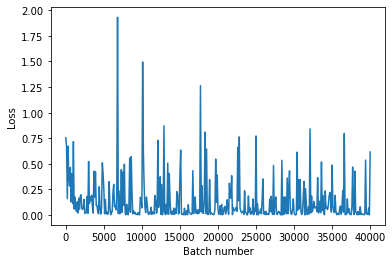

In [29]:
%%time

net = HierarchicalAttentionNetwork(len(vocab), 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
n_epochs = 1
losses = []
iterations = []

train = True # Whether or not we should train the network, or just load it

# Train the network
if train:
    for epoch in range(1,n_epochs+1):
        for i_batch, sampled_batch in enumerate(dataloader):
            documents = [[a.to(device) for a in b] for b in sampled_batch[1]]
            target = torch.tensor(sampled_batch[0]).to(device)
            prediction, _, _ = net(documents)

            loss = loss_f(prediction, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i_batch % 100 == 0:
                with torch.no_grad():
                    losses.append(loss.cpu().numpy())
                    iterations.append(i_batch*epoch)
                    print('Iteration ' + str(i_batch*epoch) + ' : Loss ' + str(loss.cpu().numpy()))

            # Stop training prematurely, as this is only a small experiment
            if i_batch == 40000:
                break

    torch.save(net.state_dict(), 'net.pt')

    plt.plot(iterations, losses)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    
# Load the network
else:
    net.load_state_dict(torch.load('net.pt'))

Let's compute the accuracy on the test set.

In [40]:
csv_test = pd.read_csv(testfile, header=None)
dataset_test = YelpReviewsDataset(tokenizer=tokenizer, vocab=vocab, csv=csv_test,\
                                  transform=ToTensor())

dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

num_correct = 0
misclassified = []

for i_batch, batch in enumerate(dataloader_test):
    documents = [[a.to(device) for a in b] for b in batch[1]]
    targets = torch.tensor(batch[0]).to(device)
    prediction, _, _ = net(documents)
    _, ind = torch.max(prediction, dim=1)
    if targets == ind:
        num_correct += 1
    else:
        misclassified.append(i_batch)

In [41]:
print('Test accuracy = ' + str(num_correct/len(dataloader_test)))

Test accuracy = 0.9512368421052632


Not bad, we hadn't even finished a single epoch of training. Let's see an example of what the network thinks is hard to classify.

In [45]:
def print_prediction(batch):
    documents = [[a.to(device) for a in b] for b in batch[1]]
    targets = torch.tensor(batch[0]).to(device)
    prediction, _, _ = net(documents)
    _, ind = torch.max(prediction, dim=1)

    print('The network predicted ' + ('negative' if ind == 0 else 'positive') + \
          ', but the example is labeled ' + ('negative' if targets == 0 else 'positive') + '.')
    print('')
    print('The review is:')
    for sentence in documents[0]:
        for word in sentence:
            print(vocab.itos[word], end=' ')
            
batch = dataset_test[misclassified[0]]
print_prediction(batch)

The network predicted negative, but the example is labeled positive.

The review is:
i went to a bob <unk> laser show as a ' favor ' for my husband . . . the <unk> were really cool . i would not recommend them if you are <unk> to <unk> , or have a <unk> <unk> , such as <unk> . \ni think if the music was more my taste , it would have been awesome . 

This review is tricky, the person did not like their experience, but they think that someone else with different tastes might. Personally, I would have also have also mislabeled this as negative.

Let's see another.

In [46]:
batch = dataset_test[misclassified[1]]
print_prediction(batch)

The network predicted negative, but the example is labeled positive.

The review is:
seattle may have just won the 2014 super bowl , but the steelers still rock with six rings , baby ! ! ! just stating what all <unk> fans know a steel <unk> is still unmatched no matter what team claims the title of current super bowl <unk> . . go steelers ! ! ! 

It's not clear what is being reviewed here (probably a stadium?), but the network should have been able to classify the sentiment as positive. Our dataset likely contains more reviews like this one, where the actual product being reviewed is never mentioned.

Let's see one more.

In [48]:
batch = dataset_test[misclassified[2]]
print_prediction(batch)

The network predicted negative, but the example is labeled positive.

The review is:
something different here . \n\nfood , <unk> , go there and drink the beers from the beer cave . i don ' t think you have to wait for the server to open your beer , they ' ll notice and charge your accordingly . it ' s all walk in and self service beer , why don ' t more places do that ? ! <unk> 

It seems that the network is not making mistakes on examples with an obvious sentiment class, and is misclassifying the reviews which require more subtlety.

Now let's visualize the attention the network is giving to each word and sentence.

In [49]:
def split_into_sentences(line):
    tokenized_line = np.array([vocab[token] for token in tokenizer(line)])
    punctuation = (tokenized_line==vocab["."]) | (tokenized_line==vocab["!"]) | (tokenized_line==vocab["?"])
    split_line = np.split(tokenized_line, (punctuation).nonzero()[0]+1)
    if len(split_line[-1]) == 0:
        return [torch.from_numpy(a).to(device) for a in split_line[:-1]]
    else:
        return [torch.from_numpy(a).to(device) for a in split_line]
    
### This block is modified from https://gist.github.com/ihsgnef/f13c35cd46624c8f458a4d23589ac768
### The idea is to visualize the attention by placing each word in a colored
### HTML span, and then render the HTML
import matplotlib

def colorize(review, sentAttn, docAttn):
    cmapWord = matplotlib.cm.get_cmap('Blues')
    cmapSent = matplotlib.cm.get_cmap('Reds')
    template_document = '<div style="background-color: {}; padding: 3pt;">{}</div>'
    template_sentence = '<span class="barcode"; style="font-size:9pt; color: black; background-color: {}">{}</span>'
    doc_string = ''
    
    text = []
    for t, sentence in enumerate(review[0]):
        text.append([])
        for word in sentence:
            w = vocab.itos[word]
            # <unk> appears as an HTML tag, so change this manually
            text[t].append('&lt;unk&gt;' if w == '<unk>' else w)
    
    for t, sentence in enumerate(text):
        sentence_string = ''
        for k, word in enumerate(sentence):
            color = matplotlib.colors.rgb2hex(cmapWord(sentAttn[t][k])[:3])
            sentence_string += template_sentence.format(color, '&nbsp;' + word + '&nbsp;')
        sAttn = docAttn[t]
        sColor = matplotlib.colors.rgb2hex(cmapSent(docAttn[t])[:3])
        doc_string += template_document.format(sColor, sentence_string)
        
    return doc_string
###

from IPython.display import display, HTML

def vis_review(review):
    with torch.no_grad():
        processed_doc = [split_into_sentences(review)]
        prediction, sentAttn, docAttn = net(processed_doc)
        numpySentAttn = [s.view(-1).cpu().numpy() for s in sentAttn[0]]
        numpyDocAttn = docAttn[0].view(-1).cpu().numpy()
        html = colorize(processed_doc, numpySentAttn, numpyDocAttn)
        display(HTML(html))
        _, ind = torch.max(prediction, dim=1)
        pred_prob = F.softmax(prediction, dim=1)[0][ind].cpu().numpy()[0]
        print('The network predicted ' + ('negative' if ind == 0 else 'positive') + \
              ' with probability ' + str(pred_prob) + '.')

In [50]:
review = csv.iloc[0,1].replace('Dr.', 'Dr')
vis_review(review)

The network predicted negative with probability 0.9998715.


The first review of the dataset is correctly classified as negative. Some words related to sentiment have been given higher weights ("unfortunately", "terrible"), but the attention is still not completely human interpretable. From a human perspective, one may conclude that the attention is underdeveloped given the limited training. In particular, it seems that the sentence level attention (shown in red) has yet to develop sufficiently with the amount of training completed, all the sentences are given nearly the same weight. However, all of this is from a human interpretability standpoint. It may be the case that this way of assigning attention may be effective for this particular task. We did get ~95% accuracy on the test set after all.

I have modified all "Dr." to "Dr" in this review to show something quite interesting with the last sentence (it's classified correctly without this change). The words "2 stars" appears in the review. This is the label for this review in the review itself! The network correctly weights "2 stars" with a high level of attention.

Now we can try this on the $3^{rd}$ misclassified review we had selected. Because of the attention visualization, we can qualitatively test why the review was misclassified.

In [51]:
review = csv_test.iloc[misclassified[2], 1]
vis_review(review)

The network predicted negative with probability 0.79980457.


This review doesn't contain strong adjectives, e.g. "good", "bad", that the network can use to classify the sentiment. Instead, it may be using a negative connotation of words like "different" and "notice" (it may be the case that people typically only "notice" bad things in their reviews). The network is only giving a confidence of $0.7998$ to its answer, instead of $0.9999$ in the previous example, indicating that it is indeed confused on the correct classification.

Let's examine some random reviews from the test set.

In [38]:
rand_inds = np.random.choice(list(range(len(csv_test))), size=(5,), replace=False)
for ind in rand_inds:
    review = csv_test.iloc[ind, 1]
    vis_review(review)
    print('The correct label is ' + ('negative' if csv_test.iloc[ind, 0] == 1 else 'positive') + '.') #1 - Negative, 2 - Positive

The network predicted positive with probability 0.9996431.
The correct label is positive.


The network predicted negative with probability 0.99863416.
The correct label is negative.


The network predicted negative with probability 0.99822503.
The correct label is negative.


The network predicted positive with probability 0.97646683.
The correct label is positive.


The network predicted negative with probability 0.8841837.
The correct label is negative.


The network is classifying these review correctly. The sentences produced from repeated exclamation points are given lower attention than regular sentences. Adjectives that carry sentiment are also frequently given a high attention weighting. Although not ideal, I find the attention results quite impressive.

Now let's write our own simple reviews and visualize the network's attention on them.

In [55]:
review = "This restaurant is a short walk from my house. Great food, great service!"
vis_review(review)

review = \
"I've been going to this bar for a long time and have good memories of it. " + \
"However, it's no longer the place I knew. The staff are rude and place is dirty." 
vis_review(review)

review = "If I say car I mean good. If I say water I mean bad. This place is car."
vis_review(review)

The network predicted positive with probability 0.9824808.


The network predicted negative with probability 0.9971058.


The network predicted negative with probability 0.6193827.


Our examples here are increasing in difficulty. In our second example, we say something positive before switching to saying something negative. The network is able to correctly classify this. The last example is unrealistically tricky just to see what the network can do. It assigns a low confidence to its wrong answer.

## Conclusion
After reviewing hierarchical attention networks, we examined and prepared the "Yelp Review Polarity" dataset. We then implemented and trained a hierarchical attention network on this task. We achieved an accuracy of roughly 95% on the test set. The attention mechanism allowed us to visualize the network's "reasoning" over words and sentences. We did this on a few examples and saw interesting results emerge.